In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.special as sc
import scipy.integrate as integ 

# Section 1 - Import Data & Define Functions

In [31]:
directory = r"C:\Users\bethx\OneDrive\Documents\Final_Year_Modules\Advanced Lab 2\Fresnel\new_data"
file_list=os.listdir(directory)

In [32]:
data_dict = {}

for filename in file_list:
    
    file_path = os.path.join(directory,filename)
    
    if os.path.isfile(file_path):
        
        data = pd.read_csv(file_path)
        
    data_dict[filename] = data

In [33]:
#data_dict

In [34]:
def find_mean(data1,data2,data3):
    
    mean_data = []
    std_data = []
    for i in np.arange(0,len(data1),1):
    
        A1 = data1[i]
        A2 = data2[i]
        A3 = data3[i]

        mean = (A1+A2+A3)/3
        std = np.std([A1,A2,A3])
        mean_data.append(mean)
        std_data.append(std)
        
    return mean_data, std_data

# Section 2 - Get I0

In [35]:
ABG = np.array(data_dict['runBG.csv']['amp'])
PBG = np.array(data_dict['runBG.csv']['phase'])
ABG2 = np.array(data_dict['runBG2.csv']['amp'])
PBG2 = np.array(data_dict['runBG2.csv']['phase'])
ABG3 = np.array(data_dict['runBG3.csv']['amp'])
PBG3 = np.array(data_dict['runBG3.csv']['phase'])

In [36]:
mean_BG_amp,std_amp = find_mean(ABG,ABG2,ABG3)
#len(mean_BG_amp)

In [37]:
x = np.linspace(-0.25,0.25,399)

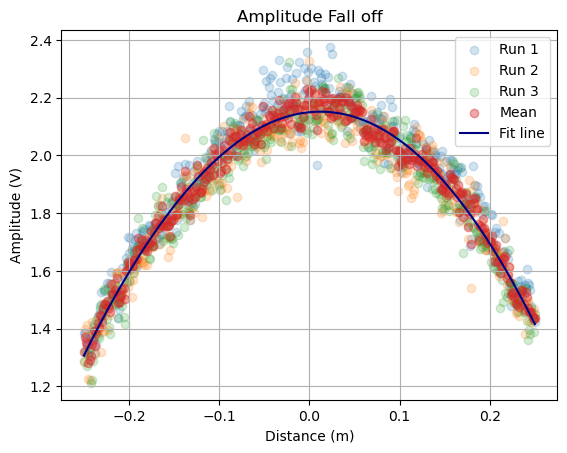

In [38]:
plt.scatter(x,ABG,alpha=0.2,label='Run 1')
plt.scatter(x,ABG2,alpha=0.2,label='Run 2')
plt.scatter(x,ABG3,alpha=0.2,label='Run 3')
plt.scatter(x,mean_BG_amp,alpha=0.4,label='Mean')

a,b,c,d = np.polyfit(x,mean_BG_amp,3)
plt.plot(x,a*x**3+b*x**2+c*x+d,color='navy',label='Fit line')

plt.title('Amplitude Fall off')
plt.xlabel('Distance (m)')
plt.ylabel('Amplitude (V)')
plt.grid()
plt.legend()

In [39]:
def amp_correction(x1):
    corr = a*x1**3+b*x1**2+c*x1+d
    return corr

In [40]:
i0= amp_correction(x+0.02)

# Section 3 - Straight Edge

## Section 3.0 - Get Theoretical expectation

In [41]:
def theoretical_straight_edge(z1,z,yy):
    Y = (z1/(z+z1))*yy
    lam = 343/(40000)
    
    V1 = (np.sqrt((2*z1+2*z)/(lam*z1*z)))*Y
    S,C = sc.fresnel(V1)
    
    ans = (1/4)*np.abs(1+1j)**2*np.abs(1/2*(1+1j)-C-1j*S)**2
    return ans,C,S

In [42]:
def apply_rotate(x,y,theta):
    
    x_prime = x*np.cos(theta)-y*np.sin(theta)
    y_prime = x*np.sin(theta)+y*np.cos(theta)
    
    return x_prime,y_prime

In [43]:
def rotate_Cornu(raw_amp,raw_phase,index,index2):
    phasor_x = ((raw_amp[index2:400]/i0[index2:400])*np.cos(raw_phase[index2:400]))
    phasor_y = (raw_amp[index2:400]/i0[index2:400])*np.sin(raw_phase[index2:400])
    
    x_shifted = (raw_amp[index]/i0[index])*np.cos(raw_phase[index])
    y_shifted = (raw_amp[index]/i0[index])*np.sin(raw_phase[index])
    print(x_shifted,y_shifted)
    
    shifted_x_data = phasor_x+x_shifted
    shifted_y_data = phasor_y+y_shifted    ## shift end of cornu to (0,0)
    
    u = (-1*x_shifted,y_shifted)             ## two vectors to calculate angle between
    v = (0.5,0.5)
    
    theta = np.dot(u,v)/((1/np.sqrt(2))*(np.sqrt(x_shifted**2+y_shifted**2)))
    angle = np.arccos(theta)
    
    Xp,Yp = apply_rotate(phasor_x,phasor_y,-1*angle)    ## apply rotation
    
    return Xp+0.5,Yp-0.5

In [44]:
def Fresnel_zone_radii(n,z,z1):
    lam = 343/(40000)
    Rm = np.sqrt(n*lam*(1/z+1/z1))
    return Rm

In [45]:
def error_Fresnel_x(A,p,Da,Dp):
    err_x = np.sqrt((np.cos(p))**2*Da**2+(A*np.sin(p))**2*Dp**2)
    return err_x

In [46]:
def error_Fresnel_y(A,p,Da,Dp):
    err_y = np.sqrt((np.sin(p))**2*Da**2+(A*np.cos(p))**2*Dp**2)
    return err_y

## Section 3.1: z = 0.61

In [47]:
ans_1,C_1,S_1 = theoretical_straight_edge(1.04-.61,0.61,x)    ## z prime = total - z

In [48]:
A2 = np.array(data_dict['run2.csv']['amp'])
P2 = np.array(data_dict['run2.csv']['phase'])
A3 = np.array(data_dict['run3.csv']['amp'])
P3 = np.array(data_dict['run3.csv']['phase'])
A4 = np.array(data_dict['run4.csv']['amp'])
P4 = np.array(data_dict['run4.csv']['phase'])

In [49]:
m = np.arange(0,10,1)
Rms = Fresnel_zone_radii(m,1.04-0.61,0.61)
#print(Rms)

Text(0, 0.5, 'I/I0')

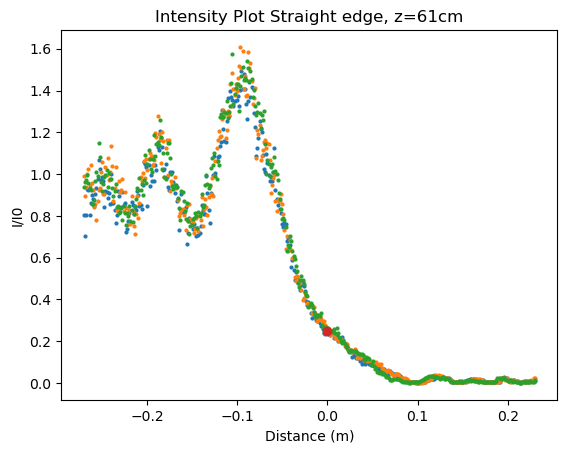

In [50]:
plt.scatter(x-0.02,(A2/i0)**2,s=4)
plt.scatter(x-0.02,(A3/i0)**2,s=4)
plt.scatter(x-0.02,(A4/i0)**2,s=4)
#plt.plot(x,ex1)
plt.scatter(0,0.25)
#(1.38/np.max((A2/i0)**2))
#[plt.axvline(x,ls='--',color='teal')for x in -1*Rms/2]

plt.title('Intensity Plot Straight edge, z=61cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

Text(0, 0.5, '')

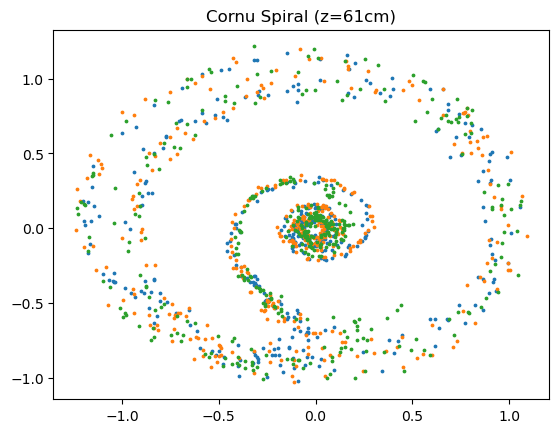

In [51]:
plt.scatter(((A2/i0)*np.cos(P2)),(A2/i0)*np.sin(P2),s=3)
plt.scatter(((A3/i0)*np.cos(P3)),(A3/i0)*np.sin(P3),s=3)
plt.scatter(((A4/i0)*np.cos(P4)),(A4/i0)*np.sin(P4),s=3)

plt.title('Cornu Spiral (z=61cm)')
plt.xlabel('')
plt.ylabel('')

In [52]:
mean_amp_d_61, std_amp_61 = find_mean(A2,A3,A4)
mean_phase_d_61, std_phase_61 = find_mean(P2,P3,P4)

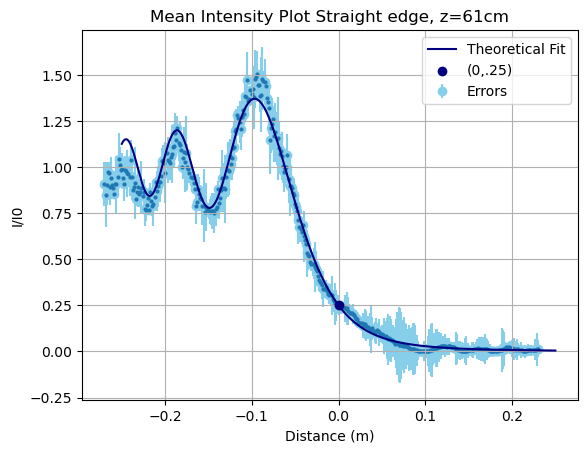

In [53]:
plt.scatter(x-0.02,(mean_amp_d_61/(i0))**2,s=4)
plt.plot(x,ans_1,color='navy',label='Theoretical Fit')
plt.scatter(0,0.25,zorder=5,color='navy',label='(0,.25)')
plt.errorbar(x-0.02,(mean_amp_d_61/(i0))**2,yerr=2*np.array(std_amp_61),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Intensity Plot Straight edge, z=61cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.legend()
plt.grid()

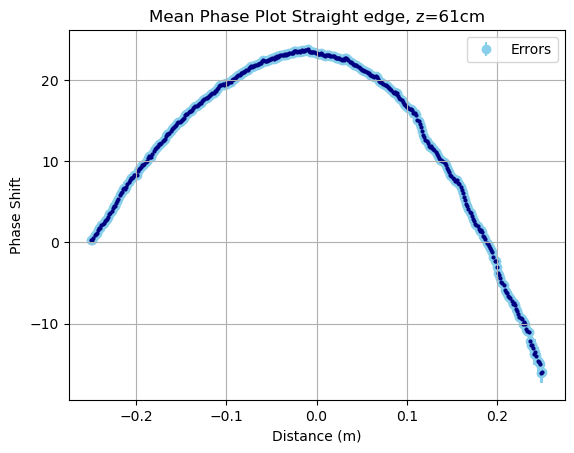

In [54]:
plt.scatter(x,(mean_phase_d_61),s=4,color='navy')
plt.errorbar(x,mean_phase_d_61,yerr=np.array(std_phase_61),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Straight edge, z=61cm')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

In [55]:
RX1, RY1 = rotate_Cornu(mean_amp_d_61,mean_phase_d_61,195,195)

-0.030102571792506774 -0.6602194810934401


In [56]:
x_errs_1 =error_Fresnel_x(np.array(mean_amp_d_61),np.array(mean_phase_d_61),np.array(std_amp_61),np.array(std_phase_61))
y_errs_1 =error_Fresnel_y(np.array(mean_amp_d_61),np.array(mean_phase_d_61),np.array(std_amp_61),np.array(std_phase_61))

Text(0, 0.5, 'Imaginary Axis')

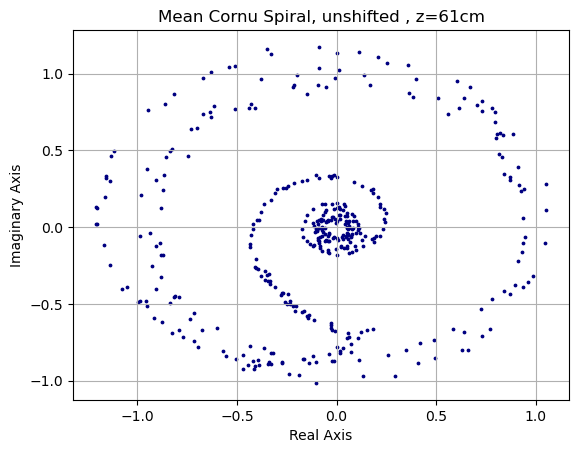

In [57]:
plt.scatter(((mean_amp_d_61/i0)*np.cos(mean_phase_d_61)),(mean_amp_d_61/i0)*np.sin(mean_phase_d_61),s=3,color='navy')
plt.title('Mean Cornu Spiral, unshifted , z=61cm')
plt.xlabel('Real Axis')
plt.grid()
plt.ylabel('Imaginary Axis')

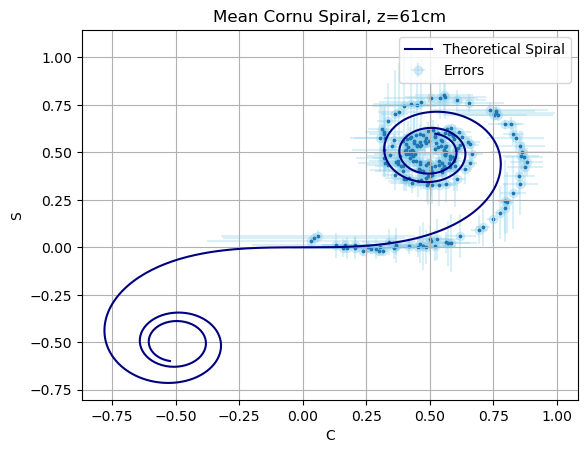

In [58]:
plt.plot(C_1,S_1,color='navy',label='Theoretical Spiral')
plt.scatter(RX1,-1*RY1,s=3)
plt.errorbar(RX1,-1*RY1,yerr=np.array(y_errs_1[195:400]),xerr=x_errs_1[195:400],fmt='o',alpha=0.3,zorder=0,color='skyblue',label='Errors')

plt.title('Mean Cornu Spiral, z=61cm')
plt.xlabel('C')
plt.grid()
plt.ylabel('S')
plt.legend()

# Section 3.2 - z = .88

In [59]:
ans_2,C_2,S_2 = theoretical_straight_edge(1.04-.88,0.88,x)

In [60]:
A5 = np.array(data_dict['run5.csv']['amp'])
P5 = np.array(data_dict['run5.csv']['phase'])
A6 = np.array(data_dict['run6.csv']['amp'])
P6 = np.array(data_dict['run6.csv']['phase'])
A7 = np.array(data_dict['run7.csv']['amp'])
P7 = np.array(data_dict['run7.csv']['phase'])

Text(0, 0.5, 'I/I0')

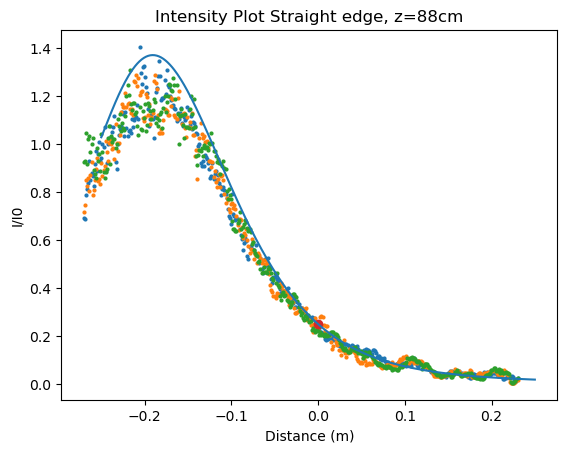

In [61]:
plt.scatter(x-0.02,(A5/i0)**2,s=4)
plt.scatter(x-.02,(A6/i0)**2,s=4)
plt.scatter(x-0.02,(A7/i0)**2,s=4)
plt.plot(x,ans_2)
plt.scatter(0,0.25)

plt.title('Intensity Plot Straight edge, z=88cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

Text(0, 0.5, '')

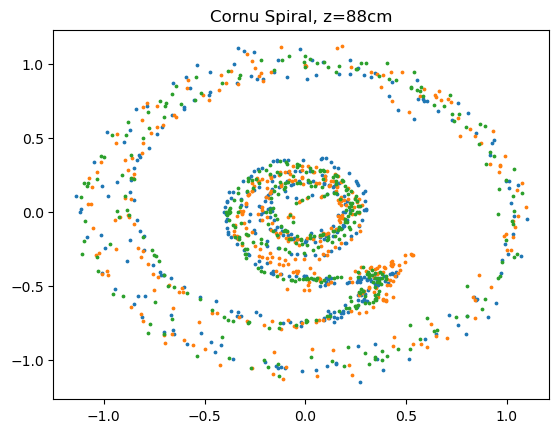

In [62]:
plt.scatter(((A5/i0)*np.cos(P5)),(A5/i0)*np.sin(P5),s=3)
plt.scatter(((A6/i0)*np.cos(P6)),(A6/i0)*np.sin(P6),s=3)
plt.scatter(((A7/i0)*np.cos(P7)),(A7/i0)*np.sin(P7),s=3)

plt.title('Cornu Spiral, z=88cm')
plt.xlabel('')
plt.ylabel('')

In [63]:
mean_amp_d_88,std_amp_88 = find_mean(A5,A6,A7)
mean_phase_d_88,std_phase_88 = find_mean(P5,P6,P7)

Text(0, 0.5, 'Imaginary Axis')

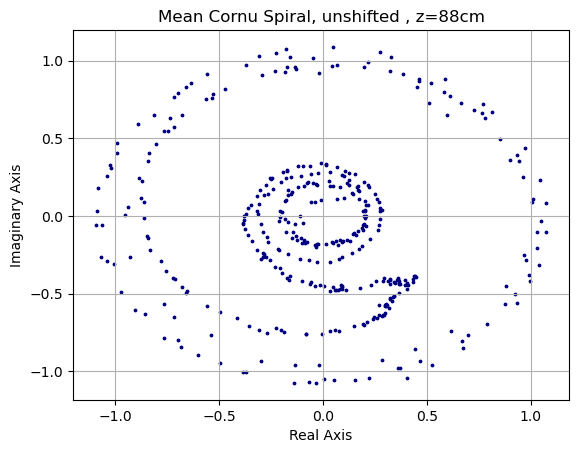

In [64]:
plt.scatter(((mean_amp_d_88/i0)*np.cos(mean_phase_d_88)),(mean_amp_d_88/i0)*np.sin(mean_phase_d_88),s=3,color='navy')
plt.title('Mean Cornu Spiral, unshifted , z=88cm')
plt.xlabel('Real Axis')
plt.grid()
plt.ylabel('Imaginary Axis')

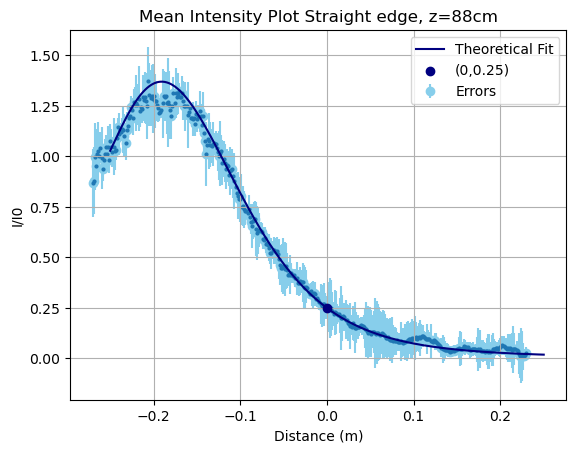

In [65]:
plt.scatter(x-0.02,(mean_amp_d_88/(i0-0.08))**2,s=4)
plt.plot(x,ans_2,color='navy',label='Theoretical Fit')
plt.errorbar(x-0.02,(mean_amp_d_88/(i0-0.08))**2,yerr=2*np.array(std_amp_88),fmt='o',zorder=0,color='skyblue',label='Errors')
plt.scatter(0,0.25,zorder=5,color='navy',label='(0,0.25)')

plt.title('Mean Intensity Plot Straight edge, z=88cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

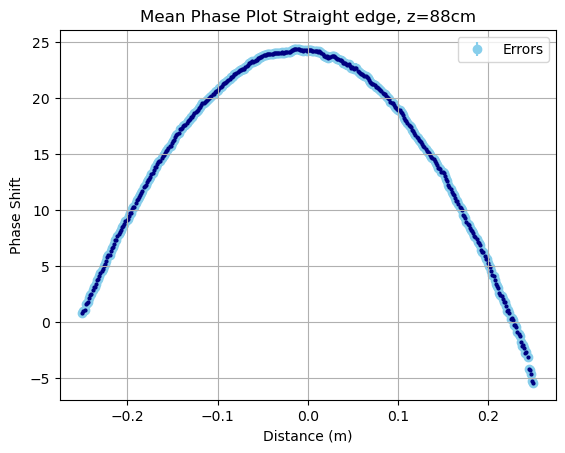

In [66]:
plt.scatter(x,(mean_phase_d_88),s=4,color='navy')
plt.errorbar(x,mean_phase_d_88,yerr=np.array(std_phase_88),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Straight edge, z=88cm')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

In [67]:
RX2, RY2 = rotate_Cornu(mean_amp_d_88,mean_phase_d_88,190,195)

0.44939843220733033 -0.39206292142535754


In [68]:
x_errs_2 =error_Fresnel_x(np.array(mean_amp_d_88),np.array(mean_phase_d_88),np.array(std_amp_88),np.array(std_phase_88))
y_errs_2 =error_Fresnel_y(np.array(mean_amp_d_88),np.array(mean_phase_d_88),np.array(std_amp_88),np.array(std_phase_88))

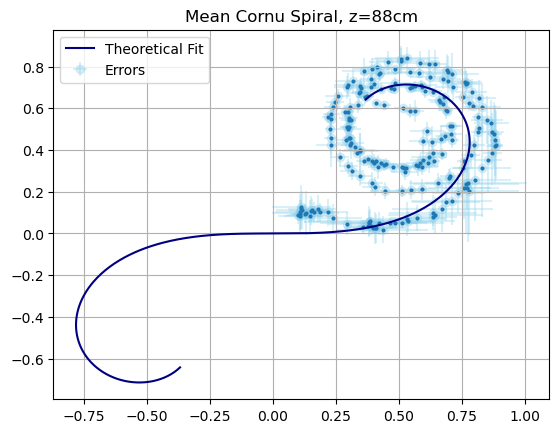

In [69]:
plt.scatter(RX2,-1*RY2,s=4)
plt.plot(C_2,S_2,color='navy',label='Theoretical Fit')
plt.errorbar(RX2,-1*RY2,yerr=(y_errs_2[195:400]),xerr=x_errs_2[195:400],alpha=0.3,fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Cornu Spiral, z=88cm')
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.legend()

## Section 3.3 - z= .28

In [70]:
ans_3,C_3,S_3 = theoretical_straight_edge(1.04-.28,0.28,x)    ## z prime = total - z

In [71]:
A8 = np.array(data_dict['run8.csv']['amp'])
P8 = np.array(data_dict['run8.csv']['phase'])
A9 = np.array(data_dict['run9.csv']['amp'])
P9 = np.array(data_dict['run9.csv']['phase'])
A10 = np.array(data_dict['run10.csv']['amp'])
P10 = np.array(data_dict['run10.csv']['phase'])

Text(0, 0.5, 'I/I0')

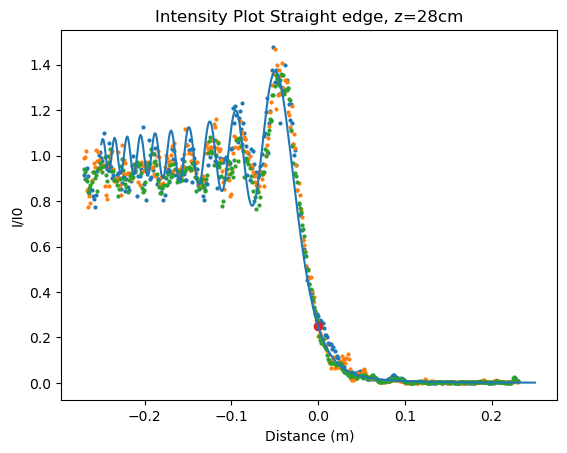

In [72]:
plt.scatter(x-0.02,(A8/i0)**2,s=4)
plt.scatter(x-0.02,(A9/i0)**2,s=4)
plt.scatter(x-0.02,(A10/i0)**2,s=4)
plt.plot(x,ans_3)
plt.scatter(0,0.25)

plt.title('Intensity Plot Straight edge, z=28cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

Text(0, 0.5, '')

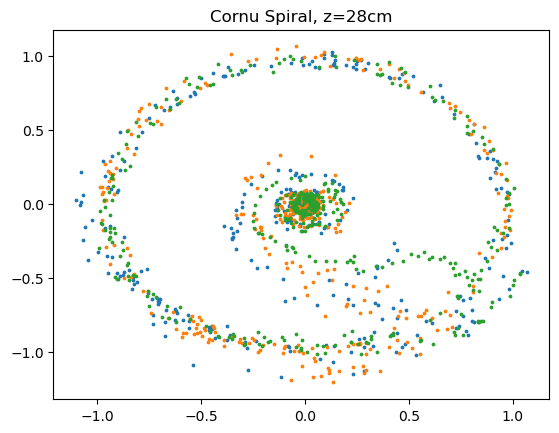

In [73]:
plt.scatter(((A8/i0)*np.cos(P8)),(A8/i0)*np.sin(P8),s=3)
plt.scatter(((A9/i0)*np.cos(P9)),(A9/i0)*np.sin(P9),s=3)
plt.scatter(((A10/i0)*np.cos(P10)),(A10/i0)*np.sin(P10),s=3)

plt.title('Cornu Spiral, z=28cm')
plt.xlabel('')
plt.ylabel('')

In [74]:
mean_amp_d_28, std_amp_28 = find_mean(A8,A9,A10)
mean_phase_d_28, std_phase_28 = find_mean(P8,P9,P10)

Text(0, 0.5, 'Imaginary Axis')

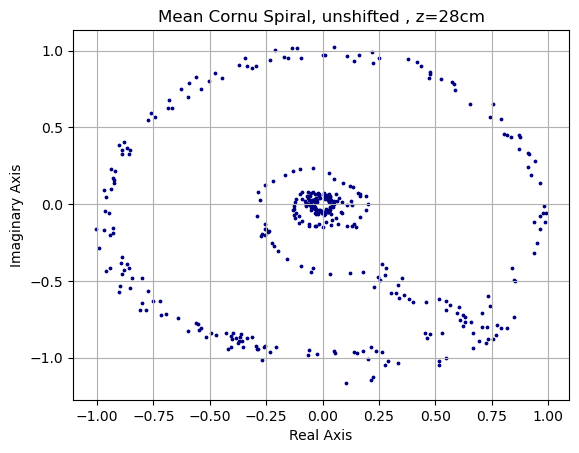

In [75]:
plt.scatter(((mean_amp_d_28/i0)*np.cos(mean_phase_d_28)),(mean_amp_d_28/i0)*np.sin(mean_phase_d_28),s=3,color='navy')
plt.title('Mean Cornu Spiral, unshifted , z=28cm')
plt.xlabel('Real Axis')
plt.grid()
plt.ylabel('Imaginary Axis')

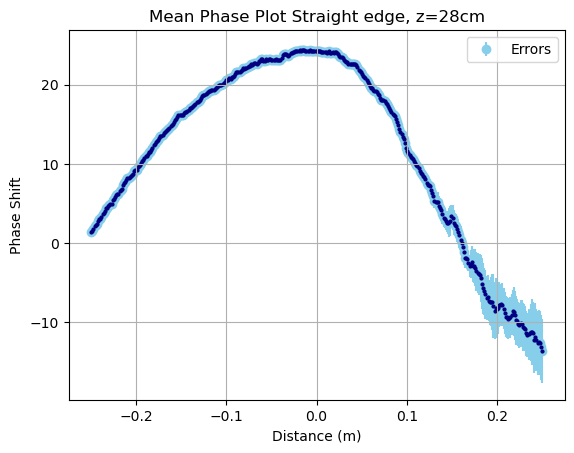

In [76]:
plt.scatter(x,(mean_phase_d_28),s=4,color='navy')
plt.errorbar(x,mean_phase_d_28,yerr=np.array(std_phase_28),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Straight edge, z=28cm')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

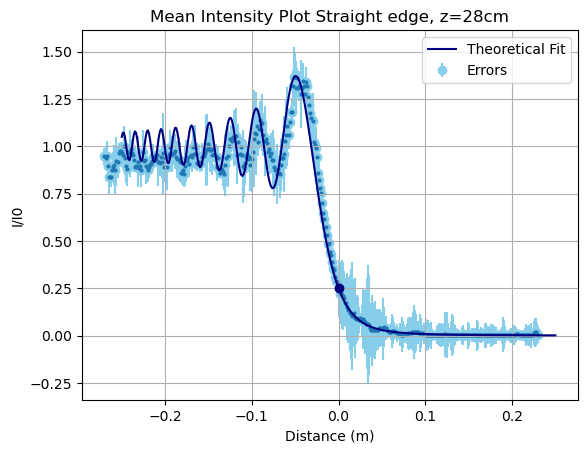

In [77]:
plt.scatter(x-0.02,(mean_amp_d_28/i0)**2,s=4)
plt.plot(x,ans_3,color='navy',label='Theoretical Fit')
plt.errorbar(x-0.02,(mean_amp_d_28/i0)**2,yerr=2*np.array(std_amp_28),fmt='o',zorder=0,color='skyblue',label='Errors')
plt.scatter(0,0.25,zorder=5,color='navy')

plt.title('Mean Intensity Plot Straight edge, z=28cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

In [78]:
RX3, RY3 = rotate_Cornu(mean_amp_d_28,mean_phase_d_28,190,200)

0.6655533206431228 -0.839528377743638


In [79]:
x_errs_3 =error_Fresnel_x(np.array(mean_amp_d_28),np.array(mean_phase_d_28),np.array(std_amp_28),np.array(std_phase_28))
y_errs_3 =error_Fresnel_y(np.array(mean_amp_d_28),np.array(mean_phase_d_28),np.array(std_amp_28),np.array(std_phase_28))

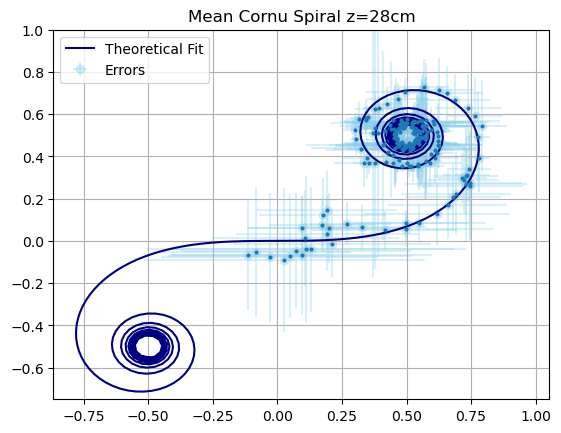

In [80]:
plt.scatter(RX3,-1*RY3,s=4,zorder=5)
plt.plot(C_3,S_3,color='navy',label='Theoretical Fit')
plt.errorbar(RX3,-1*RY3,yerr=(y_errs_3[200:400]),xerr=x_errs_3[200:400],alpha=0.3,fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Cornu Spiral z=28cm')
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.ylim(-0.75,1)
plt.legend(loc=2)

## Section 3.4 - z=.12

In [81]:
ans_4,C_4,S_4 = theoretical_straight_edge(1.04-.12,0.12,x)    ## z prime = total - z

In [82]:
A11 = np.array(data_dict['run11.csv']['amp'])
P11 = np.array(data_dict['run11.csv']['phase'])
A12 = np.array(data_dict['run12.csv']['amp'])
P12 = np.array(data_dict['run12.csv']['phase'])
A13 = np.array(data_dict['run13.csv']['amp'])
P13 = np.array(data_dict['run13.csv']['phase'])

Text(0, 0.5, 'I/I0')

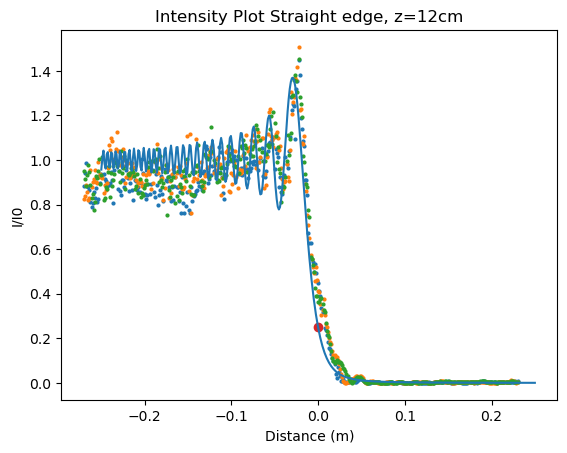

In [83]:
plt.scatter(x-.02,(A11/i0)**2,s=4)
plt.scatter(x-0.02,(A12/i0)**2,s=4)
plt.scatter(x-0.02,(A13/i0)**2,s=4)
plt.plot(x,ans_4)
plt.scatter(0,0.25)

plt.title('Intensity Plot Straight edge, z=12cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

Text(0, 0.5, '')

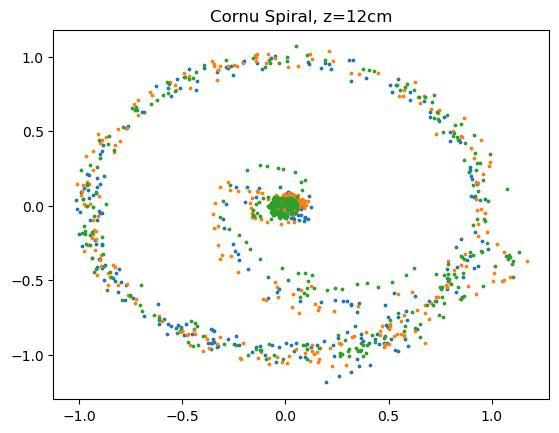

In [84]:
plt.scatter(((A11/i0)*np.cos(P11)),(A11/i0)*np.sin(P11),s=3)
plt.scatter(((A12/i0)*np.cos(P12)),(A12/i0)*np.sin(P12),s=3)
plt.scatter(((A13/i0)*np.cos(P13)),(A13/i0)*np.sin(P13),s=3)

plt.title('Cornu Spiral, z=12cm')
plt.xlabel('')
plt.ylabel('')

In [85]:
mean_amp_d_12, std_amp_12 = find_mean(A11,A12,A13)
mean_phase_d_12, std_phase_12  = find_mean(P11,P12,P13)

Text(0, 0.5, 'I/I0')

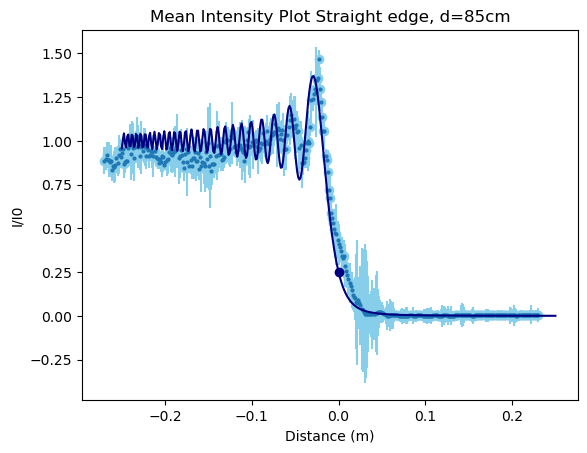

In [86]:
plt.scatter(x-0.02,(mean_amp_d_12/i0)**2,s=4)
plt.plot(x,ans_4,color='navy')
plt.scatter(0,0.25,zorder=5,color='navy')
plt.errorbar(x-0.02,(mean_amp_d_12/i0)**2,yerr=2*np.array(std_amp_12),fmt='o',zorder=0,color='skyblue')

plt.title('Mean Intensity Plot Straight edge, d=85cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [87]:
RX4, RY4 = rotate_Cornu(mean_amp_d_12,mean_phase_d_12,170,200)

0.38459663892058704 -0.9842406171042879


In [88]:
x_errs_4 =error_Fresnel_x(np.array(mean_amp_d_12),np.array(mean_phase_d_12),np.array(std_amp_12),np.array(std_phase_12))
y_errs_4 =error_Fresnel_y(np.array(mean_amp_d_12),np.array(mean_phase_d_12),np.array(std_amp_12),np.array(std_phase_12))

Text(0, 0.5, '')

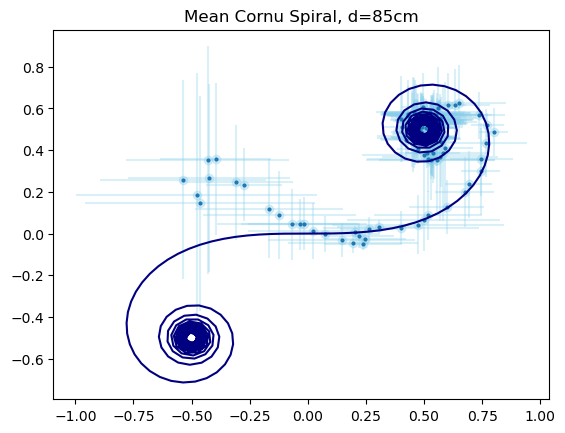

In [89]:
plt.scatter(RX4,-1*RY4,s=4)
plt.plot(C_4,S_4,color='navy')
plt.errorbar(RX4,-1*RY4,yerr=np.array(y_errs_4[200:400]),xerr=x_errs_4[200:400],alpha=0.3,fmt='o',zorder=0,color='skyblue')

plt.title('Mean Cornu Spiral, d=85cm')
plt.xlabel('')
plt.ylabel('')

## Section 3.5  - Compare Cornu spirals

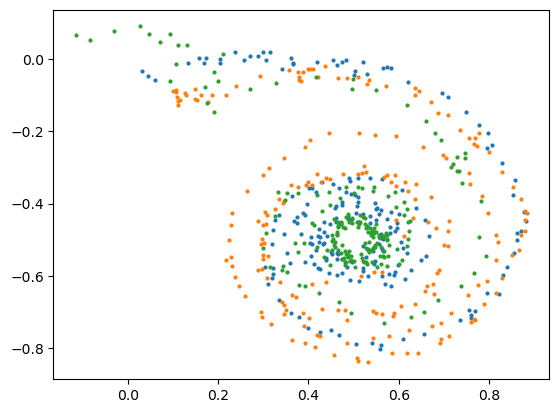

In [90]:
plt.scatter(RX1,RY1,s=4)
plt.scatter(RX2,RY2,s=4)
plt.scatter(RX3,RY3,s=4)
#plt.scatter(RX4,RY4,s=4)


#plt.scatter(((mean_amp_d_14/i0)*np.cos(mean_phase_d_14)),(mean_amp_d_14/i0)*np.sin(mean_phase_d_14),s=4)
#plt.scatter(((mean_amp_d_67/i0)*np.cos(mean_phase_d_67)),(mean_amp_d_67/i0)*np.sin(mean_phase_d_67),s=4)
#plt.scatter(((mean_amp_d_86/i0)*np.cos(mean_phase_d_86)),(mean_amp_d_86/i0)*np.sin(mean_phase_d_86),s=4)

# Section 4 - Single Slit

## Section 4.0- Theoretical fit 

In [91]:
def theoretical_single_slit(z1,z,y):
    lam = 343/(40000)
    deltaV = 0.1*np.sqrt((2*(z1+z))/(lam*z*z1))
    
    V1 = y-deltaV/2
    V2 = y + deltaV/2
        
    S1,C1 = sc.fresnel(V1)   
    S2,C2 = sc.fresnel(V2) 
   
    ans = (1/2)*np.abs(C2+1j*S2-C1-1j*S1)**2
    return ans

In [92]:
def theoretical_single_slit1(z1,z,yy):   
    Y = (z1/(z+z1))*yy
    lam = 343/(40000)
    
    V1 = (np.sqrt((2*z1+2*z)/(lam*z1*z)))*Y
    S1,C1 = sc.fresnel(V1)
    
    deltaV = 0.1*np.sqrt((2*(z1+z))/(lam*z*z1))
    V2 = deltaV +V1+0.1
    S2,C2 = sc.fresnel(V2)
    
    ans = (1/2)*np.abs(C2+1j*S2-C1-1j*S1)**2
    return ans

## Section 4.1  - Slit 1

In [93]:
A_ss1 = np.array(data_dict['ss_run1.csv']['amp'])
A_ss2 = np.array(data_dict['ss_run2.csv']['amp'])
A_ss3 = np.array(data_dict['ss_run3.csv']['amp'])
P_ss1 = np.array(data_dict['ss_run1.csv']['phass'])
P_ss2 = np.array(data_dict['ss_run2.csv']['phass'])
P_ss3 = np.array(data_dict['ss_run3.csv']['phass'])

In [94]:
ans_5 = theoretical_single_slit1(.7,1.04-.7,x-0.1)    ## z prime = total - z

Text(0, 0.5, 'I/I0')

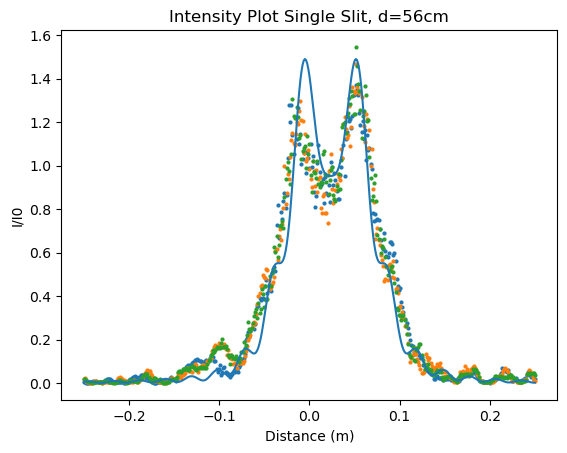

In [95]:
plt.scatter(x,(A_ss1/i0)**2,s=4)
plt.scatter(x,(A_ss2/i0)**2,s=4)
plt.scatter(x,(A_ss3/i0)**2,s=4)
plt.plot(x,ans_5)

plt.title('Intensity Plot Single Slit, d=56cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [96]:
mean_amp_ss,std_ss = find_mean(A_ss1,A_ss2,A_ss3)
mean_phase_ss,std_phase = find_mean(P_ss1,P_ss2,P_ss3)

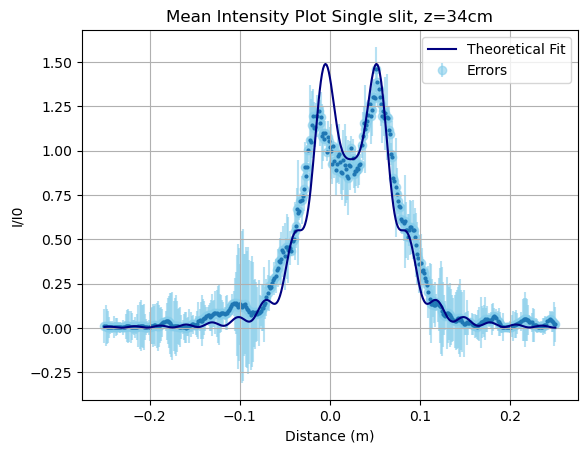

In [97]:
plt.scatter(x,(mean_amp_ss/(i0))**2,s=4)
#plt.scatter(x,(mean_amp_ss_d2/i0)**2,s=4)
plt.plot(x,ans_5,color='navy',label='Theoretical Fit')
plt.errorbar(x,(mean_amp_ss/i0)**2,yerr=2*np.array(std_ss),alpha=0.6,fmt='o',zorder=0,color='skyblue',label='Errors')


plt.title('Mean Intensity Plot Single slit, z=34cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

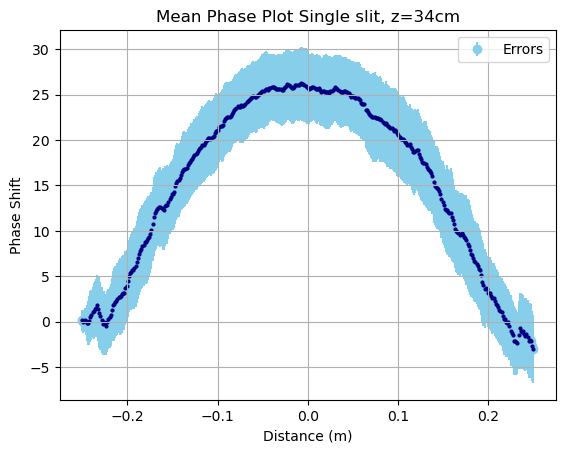

In [98]:
plt.scatter(x,(mean_phase_ss),s=4,color='navy')
plt.errorbar(x,mean_phase_ss,yerr=np.array(std_phase),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Single slit, z=34cm')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

In [99]:
A_ss1_d2 = np.array(data_dict['run_ss_d2_1.csv']['amp'])
A_ss2_d2 = np.array(data_dict['run_ss_d2_2.csv']['amp'])
A_ss3_d2 = np.array(data_dict['run_ss_d3_3.csv']['amp'])
P_ss1_d1 = np.array(data_dict['run_ss_d2_1.csv']['phasc'])
P_ss2_d2 = np.array(data_dict['run_ss_d2_2.csv']['phasc'])
P_ss3_d3 = np.array(data_dict['run_ss_d3_3.csv']['phasc'])

In [100]:
ans_6 = theoretical_single_slit1(.37,1.04-.37,x-0.22)    ## z prime = total - z

Text(0, 0.5, 'I/I0')

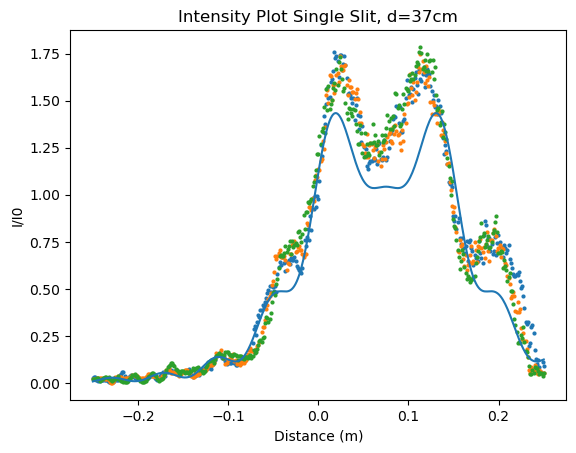

In [101]:
plt.scatter(x,(A_ss1_d2/i0)**2,s=4)
plt.scatter(x,(A_ss2_d2/i0)**2,s=4)
plt.scatter(x,(A_ss3_d2/i0)**2,s=4)
plt.plot(x,ans_6)

plt.title('Intensity Plot Single Slit, d=37cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [102]:
mean_amp_ss_d2,std_ss_d2 = find_mean(A_ss1_d2,A_ss2_d2,A_ss3_d2)
mean_phase_ss_d2, std_phase_d2 = find_mean(P_ss1_d1,P_ss2_d2,P_ss3_d3)

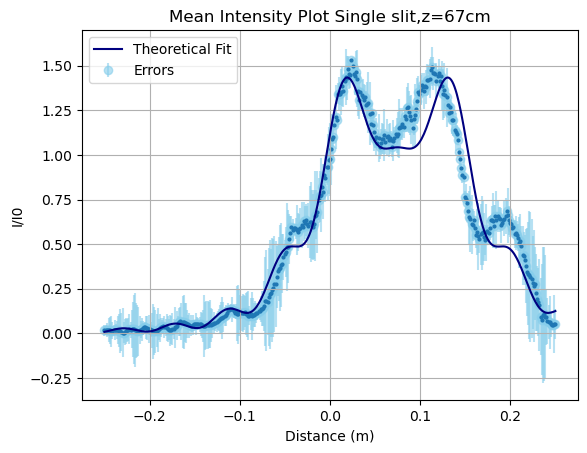

In [103]:
plt.scatter(x,(mean_amp_ss_d2/(i0+0.14))**2,s=4)
plt.plot(x,ans_6,color='navy',label='Theoretical Fit')
plt.errorbar(x,(mean_amp_ss_d2/(i0+0.14))**2,yerr=2*np.array(std_ss_d2),alpha=0.6,fmt='o',zorder=0,color='skyblue',label='Errors')


plt.title('Mean Intensity Plot Single slit,z=67cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

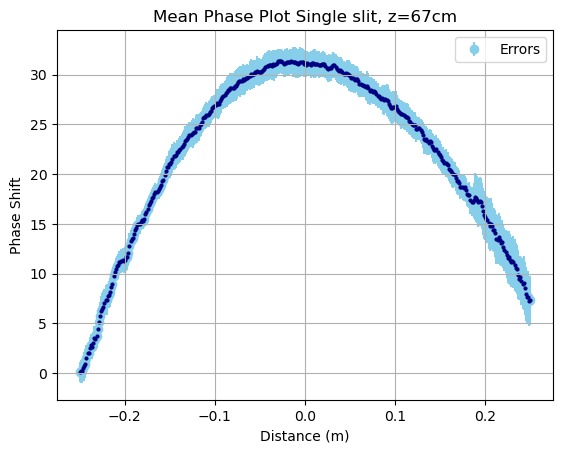

In [104]:
plt.scatter(x,(mean_phase_ss_d2),s=4,color='navy')
plt.errorbar(x,mean_phase_ss_d2,yerr=np.array(std_phase_d2),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Single slit, z=67cm')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

## Section 4.1 - Complementary Aperture

In [105]:
A_sc1 = np.array(data_dict['sc_run1.csv']['amp'])
A_sc2 = np.array(data_dict['sc_run2.csv']['amp'])
A_sc3 = np.array(data_dict['sc_run3.csv']['amp'])
P_sc1 = np.array(data_dict['sc_run1.csv']['phasc'])
P_sc2 = np.array(data_dict['sc_run2.csv']['phasc'])
P_sc3 = np.array(data_dict['sc_run3.csv']['phasc'])

Text(0, 0.5, 'I/I0')

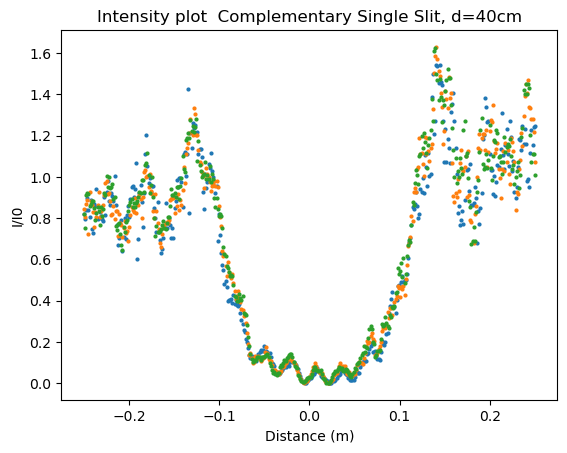

In [106]:
plt.scatter(x,(A_sc1/i0)**2,s=4)
plt.scatter(x,(A_sc2/i0)**2,s=4)
plt.scatter(x,(A_sc3/i0)**2,s=4)

plt.title('Intensity plot  Complementary Single Slit, d=40cm')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [107]:
mean_amp_sc,std_sc = find_mean(A_sc1,A_sc2,A_sc3)
mean_phase_sc,std__phase_sc = find_mean(P_sc1,P_sc2,P_sc3)

In [108]:
neg_x = np.linspace(-0.2,0.07,200)
pos_x = np.linspace(0,0.25,200)

In [109]:
ans_sc,C_sc,S_sc = theoretical_straight_edge(1.04-.44,0.44,neg_x)    ## z prime = total - z

In [110]:
ans_sc1,C_sc1,S_sc1 = theoretical_straight_edge(1.04-.44,0.44,pos_x)    ## z prime = total - z

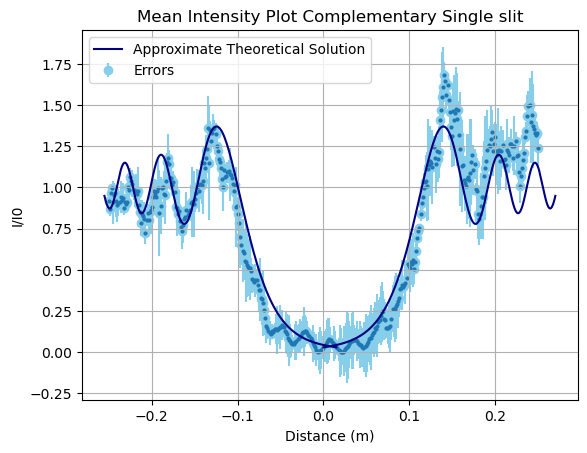

In [111]:
plt.scatter(x,(mean_amp_sc/(i0-0.07))**2,s=4)
plt.plot(neg_x-0.055,ans_sc,color='navy')
plt.plot(-1*neg_x+0.07,ans_sc,color='navy',label='Approximate Theoretical Solution')
plt.errorbar(x,(mean_amp_sc/(i0-0.07))**2,yerr=2*np.array(std_sc),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Intensity Plot Complementary Single slit')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

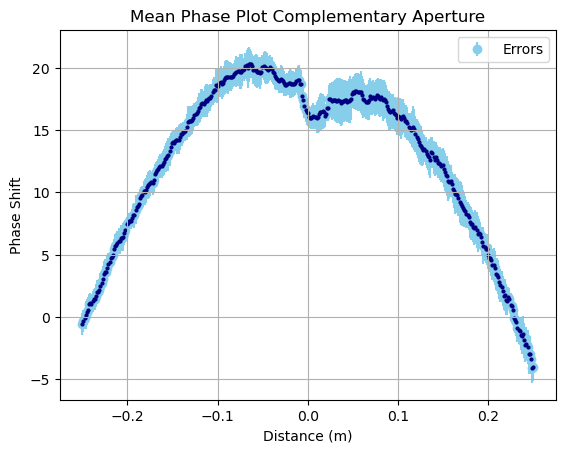

In [112]:
plt.scatter(x,(mean_phase_sc),s=4,color='navy')
plt.errorbar(x,mean_phase_sc,yerr=np.array(std__phase_sc),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Complementary Aperture')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

# Section 5 - Circular Aperture

In [113]:
def im_circle(R,Y):
    lam = 343/40000
    z1 = 0.8
    z = 1.04-0.8
    
    u = (2*np.pi*(z1+z)*0.1**2)/(lam*z1*z)
    v=(Y*2*np.pi*0.1)/(.8)
    ans = R*sc.j0(R*v)*np.sin((u*R**2))
    return ans

def RE_circle(R,Y):
    lam = 343/40000
    z1 = 0.8
    z = 1.04-0.8
    
    u = (2*np.pi*(z1+z)*0.1**2)/(lam*z1*z)
    
    v=(Y*2*np.pi*0.1)/(.8)
    return R*sc.j0(R*v)*np.cos(u*R**2)

In [114]:
    lam = 343/40000
    z1 = 0.65
    z = 1.04-0.65
    
    u = (2*np.pi*(z1+z)*0.1**2)/(lam*z1*z)

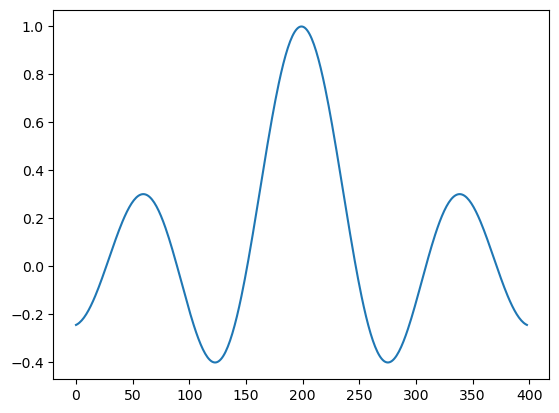

In [115]:
plt.plot(sc.j0(np.linspace(-10,10,399)))

In [116]:
##Theoretical fit circle 
def integrate_im(Y):
    return integ.quad(im_circle,0,1,args=(Y))

def integrate_re(Y):
    return integ.quad(RE_circle,0,1,args=(Y))

In [117]:
vec_int = np.vectorize(integrate_im)
vec_int_re = np.vectorize(integrate_re)

In [118]:
test_real =vec_int_re(np.linspace(-11,9,399))
test_im = vec_int(np.linspace(-11,9,399))

soln = test_real[0]+1j*test_im[0]

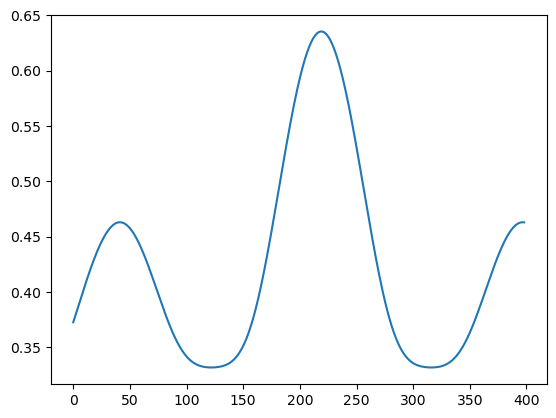

In [119]:
#plt.plot(-1*test_real[0]+0.015)
plt.plot(u*np.abs(soln))

In [120]:
A_cir1 = np.array(data_dict['cir_run1.csv']['amp'])
A_cir2 = np.array(data_dict['cir_run2.csv']['amp'])
A_cir3 = np.array(data_dict['cir_run3.csv']['amp'])
P_cir1 = np.array(data_dict['cir_run1.csv']['phasc'])
P_cir2 = np.array(data_dict['cir_run2.csv']['phasc'])
P_cir3 = np.array(data_dict['cir_run3.csv']['phasc'])

Text(0, 0.5, 'I/I0')

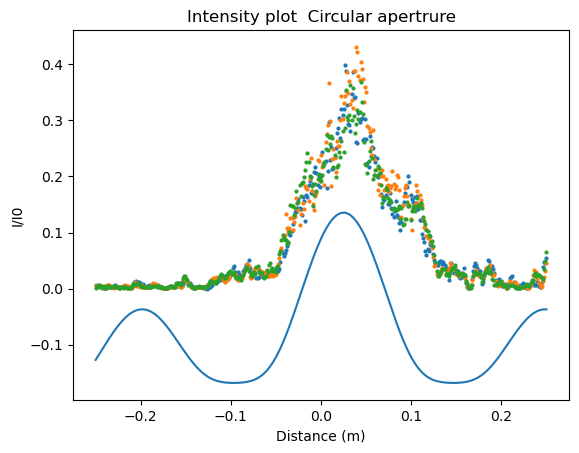

In [121]:
plt.scatter(x,(A_cir1/i0)**2,s=4)
plt.scatter(x,(A_cir2/i0)**2,s=4)
plt.scatter(x,(A_cir3/i0)**2,s=4)
plt.plot(x,u*np.abs(soln)-0.5)

plt.title('Intensity plot  Circular apertrure')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [122]:
mean_amp_cir, std_cir = find_mean(A_cir1,A_cir2,A_cir3)
mean_phase_cir, std_p_cir = find_mean(P_cir1,P_cir2,P_cir3)

In [123]:
m = np.arange(0,3,1)
Rms = Fresnel_zone_radii(m,1.04-0.61,0.61)

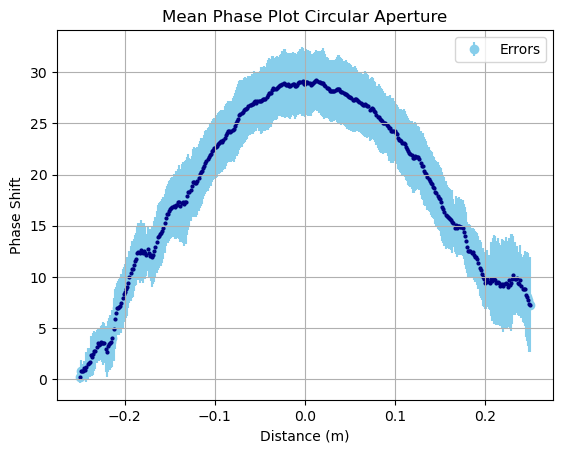

In [124]:
plt.scatter(x,(mean_phase_cir),s=4,color='navy')
plt.errorbar(x,mean_phase_cir,yerr=np.array(std_p_cir),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Circular Aperture')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()

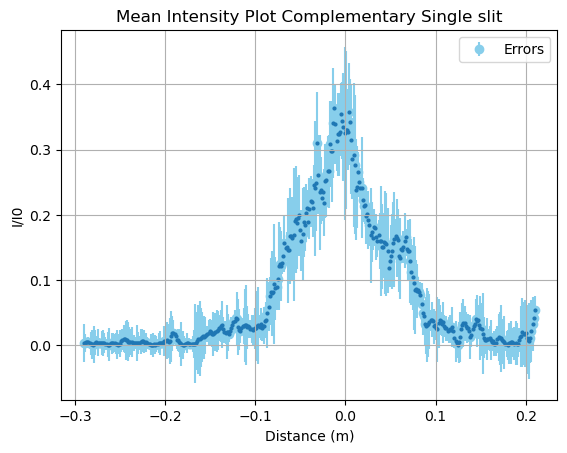

In [125]:
plt.scatter(x-0.04,np.array(mean_amp_cir/i0)**2,s=4)
#plt.plot(x-0.03,u*np.abs(soln)-0.3,color='navy',label='Attempted Theoretical Soln')
plt.errorbar(x-0.04,np.array(mean_amp_cir/i0)**2,yerr=np.array(std_cir),fmt='o',zorder=0,color='skyblue',label='Errors')


plt.title('Mean Intensity Plot Complementary Single slit')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()
plt.legend()

## Section 5.2 - Complementary circle aperture

In [126]:
A_circ1 = np.array(data_dict['circ_run1.csv']['amp'])
A_circ2 = np.array(data_dict['circ_run2.csv']['amp'])
A_circ3 = np.array(data_dict['circ_run3.csv']['amp'])
P_circ1 = np.array(data_dict['circ_run1.csv']['phasc'])
P_circ2 = np.array(data_dict['circ_run2.csv']['phasc'])
P_circ3 = np.array(data_dict['circ_run3.csv']['phasc'])

Text(0, 0.5, 'I/I0')

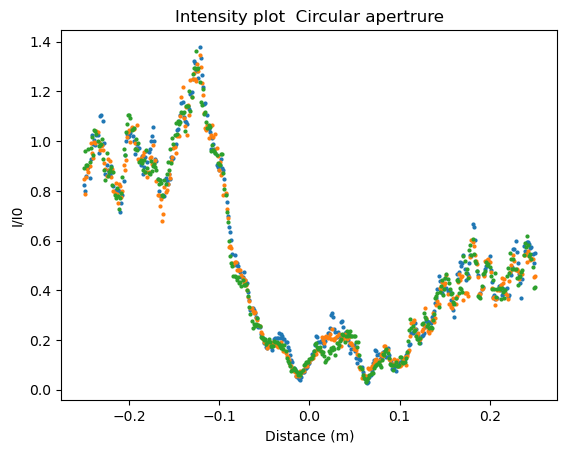

In [127]:
plt.scatter(x,(A_circ1/i0)**2,s=4)
plt.scatter(x,(A_circ2/i0)**2,s=4)
plt.scatter(x,(A_circ3/i0)**2,s=4)

plt.title('Intensity plot  Circular apertrure')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')

In [128]:
mean_amp_circ,std_sc_circ = find_mean(A_circ1,A_circ2,A_circ3)
mean_phase_circ,std_phase_circ_sc = find_mean(P_circ1,P_circ2,P_circ3)

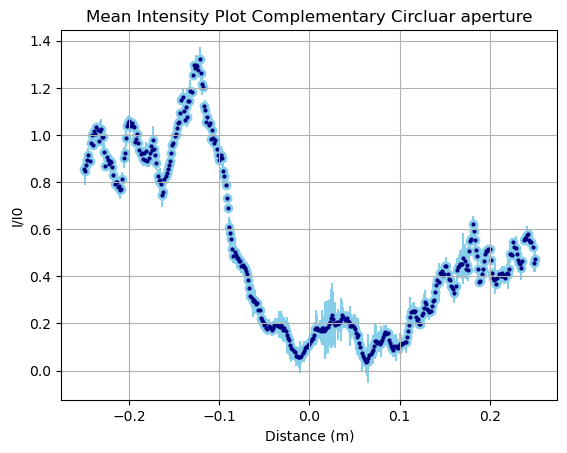

In [131]:
plt.scatter(x,(mean_amp_circ/i0)**2,s=4,color='navy')
plt.errorbar(x,np.array(mean_amp_circ/i0)**2,yerr=np.array(std_sc_circ),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Intensity Plot Complementary Circluar aperture')
plt.xlabel('Distance (m)')
plt.ylabel('I/I0')
plt.grid()

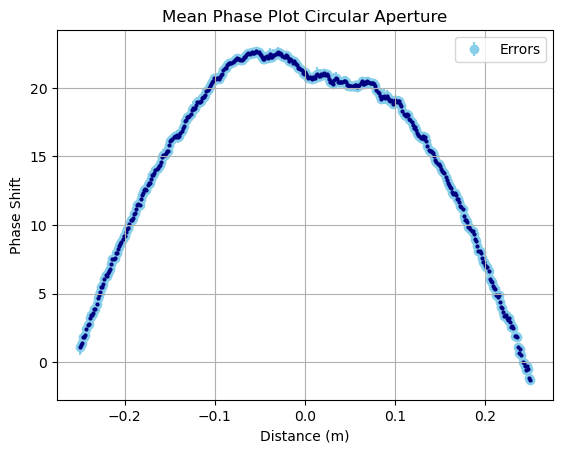

In [130]:
plt.scatter(x,(mean_phase_circ),s=4,color='navy')
plt.errorbar(x,mean_phase_circ,yerr=np.array(std_phase_circ_sc),fmt='o',zorder=0,color='skyblue',label='Errors')

plt.title('Mean Phase Plot Circular Aperture')
plt.xlabel('Distance (m)')
plt.ylabel('Phase Shift')
plt.legend()
plt.grid()